4 2


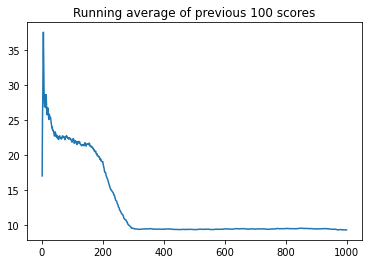

In [12]:
CUDA_LAUNCH_BLOCKING=1
import torch as T
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import numpy as np

###################################################
# Actor Critic model with discrete actions
###################################################

class Critic(nn.Module):
    def __init__(self, dim_state ,h1, h2, alpha=1e-4 ):
        super(Critic, self).__init__()
        
        self.dim_state = dim_state
        self.dim_action = dim_action
        
        self.linear1 = nn.Linear(dim_state, h1)
        self.linear2 = nn.Linear(h1, h2)
        self.linear3 = nn.Linear(h2,1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay=1e-4)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        output = state.to(self.device)
        output = F.relu(self.linear1(output))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        
        return output
    
class Actor(nn.Module):
    def __init__(self, dim_state, dim_action, alpha, fc1, fc2,):
        super(Actor, self).__init__()
        self.lr = alpha
        self.dim_state = dim_state
        self.dim_action = dim_action
        self.fc1 = fc1
        self.fc2 = fc2
        
        self.linear1 = nn.Linear(dim_state, fc1)
        self.linear2 = nn.Linear(fc1, fc2)
        self.linear3 = nn.Linear(fc2, dim_action)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay=1e-4)
        self.to(self.device)
    
    def forward(self,state):
        output = state.to(self.device)
        output = F.relu(self.linear1(output))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        
        return output 
    
class replayBuffer():
    def __init__(self, maxm_size, dim_state, dim_action):
        self.counter = 0
        self.state_mem = np.zeros((maxm_size, dim_state))
        self.action_mem = np.zeros((maxm_size))
        self.reward_mem = np.zeros(maxm_size)
        self.state_new_mem = np.zeros((maxm_size, dim_state))
        self.done_mem = np.zeros(maxm_size)
        self.maxm_size = maxm_size
        
    def store_Transaction(self, state, action, reward, state_new, done):
        index = self.counter % self.maxm_size
        
        self.state_mem[index] = state
        self.action_mem[index] = action
        self.reward_mem[index] = reward
        self.state_new_mem[index] =state_new
        self.done_mem[index] = 1.0 - done
        
        self.counter+=1
    
    def sample_Batch(self, batch_size=126):
        maxm_size = min(self.counter, self.maxm_size)
        batch = np.random.choice(maxm_size, batch_size)
        
        state_batch = self.state_mem[batch]
        action_batch = self.action_mem[batch]
        reward_batch = self.reward_mem[batch]
        state_new_batch = self.state_new_mem[batch]
        done_batch = self.done_mem[batch]
        
        return state_batch, action_batch,reward_batch,state_new_batch,done_batch
        
class Agent():
    def __init__(self, env, dim_state, dim_action, alpha, fc1, fc2, maxm_Iters=50, gamma=0.99, batch_size=126,maxm_size=3000):
        self.dim_state = dim_state
        self.dim_action = dim_action
        self.gamma = gamma
        self.maxm_Iters = maxm_Iters
        self.replayBuffer = replayBuffer(maxm_size, dim_state, dim_action) # maxm_size, dim_state, dim_action):
        self.batch_size = batch_size
        
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.critic = Critic(dim_state,fc1, fc2)
        self.actor = Actor(dim_state, dim_action, alpha, fc1, fc2)
        
    def plot_learning_curve(self, x, scores, figure_file='test'):
        running_avg = np.zeros(len(scores))
        for i in range(len(running_avg)):
            running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
        plt.plot(x, running_avg)
        plt.title('Running average of previous 100 scores')
    
    
    def train(self):
      
        reward_list = []
        for i in range(self.maxm_Iters):
            state = env.reset()
            total_reward = 0
            done= False
            
            while not done:
                self.critic.train()
                self.actor.train()
        
                self.critic.zero_grad()
                self.actor.zero_grad()
              
                probs = F.softmax(self.actor(T.tensor(state).float()), dim=0)
            
                m = Categorical(probs)
                action = m.sample().to(self.device)
            
                state_next, reward, done, _ = env.step(action.item())
                total_reward +=reward
                self.replayBuffer.store_Transaction(state, action, reward, state_next, done)
                    
                ##Update the actor and critic
                state_batch, action_batch,reward_batch,state_new_batch,done_batch = self.replayBuffer.sample_Batch(self.batch_size)

                target = torch.tensor(reward_batch).view(-1,1) + self.gamma * self.critic(T.tensor(state_new_batch).float())*T.tensor(done_batch).view(-1,1)
                state_value = self.critic(T.tensor(state_batch).float())
                advantage = target - state_value
         
                ## Loss for critic
                loss_critic = (advantage**2).mean()
                
                ## Loss for actor
                loss_actor = -m.log_prob(T.tensor(action_batch)) * T.squeeze(advantage)
                loss_actor = loss_actor.mean()
                
                (loss_critic + loss_actor).backward()
                
                self.actor.optimizer.step()
                self.critic.optimizer.step()
                
                state = state_next
            reward_list.append(total_reward)
            
        x = [i+1 for i in range(self.maxm_Iters)]
        self.plot_learning_curve(x, reward_list)
        
if __name__ == '__main__':
    env = gym.make('CartPole-v1')
    #env = gym.make('MountainCar-v0')
    dim_state = env.observation_space.shape[0]
    dim_action = env.action_space.n
    print (dim_state,dim_action )

    agent = Agent(env,dim_state,dim_action, 1e-5, 256, 256, maxm_Iters=1000)
    agent.train()
    

In [13]:
13*14

182